# configurando drive

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

# Deep Learning - parte 2: Convolutional Neural Network

Redes convolucionais são usadas principalmente para classificação de imagens.

## Como elas funcionam?

Filtros convolucionais são usados para extrair features de imagens. Vamos olhar um exemplo de como extrair bordas de imagens:

<img src="https://cdn-images-1.medium.com/max/1000/1*TAo3aselJNVwrLLr654Myg.gif" alt="drawing" width="800"/>

Nas redes convolucionais esses filtros são aplicados em várias camadas:

<img src="https://cdn-images-1.medium.com/max/1600/1*_34EtrgYk6cQxlJ2br51HQ.gif" width=700/>

Os valores dos filtros são aprendidos, portanto a própria rede aprende quais características são relevantes.

![](https://adeshpande3.github.io/assets/deconvnet.png)


## Construindo uma CNN pra predizer lateralidade do raio-X

In [3]:
# Primeiro vamos definir os imports

import warnings
warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import datetime


from keras import datasets, Model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras import backend
import tensorflow as tf
from random import randint

from keras.preprocessing.image import load_img, img_to_array

import glob

Using TensorFlow backend.


Nosso desafio é criar uma rede para aprender se um raio X é lateral ou de frente:

![alt text](https://github.com/jessica-santos/qcon_notebook/raw/066adc30051b0a5b6e6a3cbab31b00fb6b75dbd5/lateral.png)

** O ideal é sempre visualizar uma amostra das imagens de cada classe e, assim como fazemos feature engineering em variáveis, também podemos ver se é necessário fazer alguma transformação ou normalização nas imagens.

In [4]:
!ls /content/drive/images-chest-orientation

test  train


In [5]:
!ls /content/drive/images-chest-orientation/train

frente	lateral


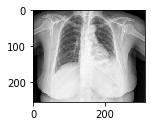

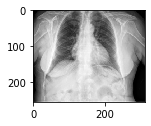

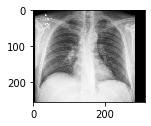

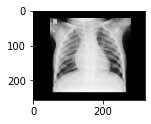

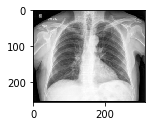

In [6]:
files_frente = glob.glob('drive/images-chest-orientation/train/frente/*.jpg')
for i in range(5):
    plt.figure(figsize=(2,2))
    indx = randint(0,len(files_frente))
    im = plt.imread(files_frente[indx])
    plt.imshow(im)

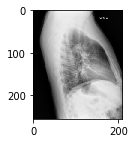

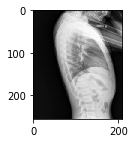

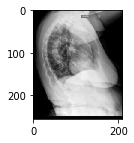

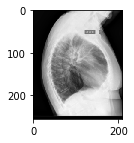

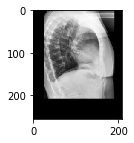

In [7]:
files_lateral = glob.glob('drive/images-chest-orientation/train/lateral/*.jpg')
for i in range(5):
    plt.figure(figsize=(2,2))
    indx = randint(0,len(files_lateral))
    im = plt.imread(files_lateral[indx])
    plt.imshow(im)


## Input de dados

Existem várias formas de inputar os dados para treinamento, vamos usar o `Image Data Generator` para ler as imagens a partir do disco

In [0]:
# aqui definimos as transformações que serão aplicadas na imagem e a % de dados 
# que serão usados para validação

#estamos nesse caso apenas normalizando a imagem dividindo por 255

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.30)

In [9]:
# para criar os generators precisamos definir o path da pasta raiz com as imagens e o tamanho da BATCH SIZE

path = '/content/drive/images-chest-orientation/train/'
BATCH_SIZE = 50


train_generator = data_generator.flow_from_directory(path, shuffle=True, seed=13, classes=['frente', 'lateral'],
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(path, shuffle=True, seed=13, classes=['frente', 'lateral'],
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 1142 images belonging to 2 classes.
Found 488 images belonging to 2 classes.


Vamos dar uma olhada em como ficaram as imagens:

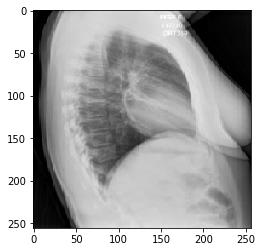

In [10]:
plt.imshow(train_generator[3][0][0])
shape = train_generator[3][0][0].shape

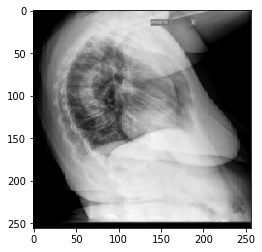

In [11]:
plt.imshow(validation_generator[1][0][2])

## Definindo a arquitetura:

Vamos criar uma rede pequena que consiga identificar corretamente essas imagens:

In [0]:
def build_model(shape):
    '''
    Constroi as camadas da rede
    :return: modelo construido
    '''
    
    model = Sequential()

    # primeira camada adiciona o shape do input
    # adiciona a funcao de ativacao
    # padding define o output da camada, "same" eh mesmo tamanho
    # tamanho do kernel (mascara)
    # quantidade de filtros (neurônios)
    # também é possível alterar a inicializacao, bias, entre outros -- https://keras.io/layers/convolutional/#conv2d
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=shape, kernel_initializer='glorot_uniform'))
    #Tamanho do downsampling
    model.add(MaxPooling2D(pool_size=2))
    # Fracao das unidades que serao zeradas
    model.add(Dropout(0.3))

    # Segunda camada
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))

    # Da um reshape no output transformando em array
    model.add(Flatten())

    # Camada full-connected 
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    #Camada de saida com o resultado das classes
    model.add(Dense(2, activation='sigmoid'))

    return model

Outros tipos de camadas utilizadas:

MaxPooling:
Realiza o downsampling pós convolução.

<img src="https://developers.google.com/machine-learning/practica/image-classification/images/maxpool_animation.gif" width=350/>




Dropout:
Em cada época desativa aleatoriamente um % de neurônios. Evita overfitting
    
<img src="https://i0.wp.com/deeplearningbook.com.br/wp-content/uploads/2018/07/rede2.png?w=310" width=300/>

In [13]:
model = build_model(shape)
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 128)       0         


In [14]:
# Compila o modelo definindo: otimizador, metrica e loss function
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Treinamento

Como lemos os dados usando um generator, o fit do keras também será usando um `fit_generator`.

Também usaremos alguns `callbacks`: 
 - ModelCheckPoint para salvar o modelo que tiver o melhor loss durante o treinamento e,
 - EarlyStop para interromper o treinamento caso a rede pare de aprender (convergiu).

In [0]:
# aqui definimos as transformações que serão aplicadas na imagem e a % de dados 
# que serão usados para validação

#estamos nesse caso apenas normalizando a imagem dividindo por 255

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.30)

In [16]:
# para criar os generators precisamos definir o path da pasta raiz com as imagens e o tamanho da BATCH SIZE

path = '/content/drive/images-chest-orientation/train/'
BATCH_SIZE = 50


train_generator = data_generator.flow_from_directory(path, shuffle=True, seed=13, classes=['frente', 'lateral'],
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(path, shuffle=True, seed=13, classes=['frente', 'lateral'],
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 1142 images belonging to 2 classes.
Found 488 images belonging to 2 classes.


In [0]:
checkpoint = ModelCheckpoint('chest_orientation_model.hdf5', 
                             monitor='val_loss', 
                             verbose=1, mode='min', 
                             save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                                   min_delta=0.001,
                                   patience=2, # geralmente colocamos no mínimo 5 epocas
                                   mode='min',
                                   verbose=1)

In [18]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch = train_generator.samples//BATCH_SIZE,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//BATCH_SIZE,
                    epochs= 50,
                    callbacks=[checkpoint, early_stop]
                    )




Epoch 1/50





22/22 [==============================] - 482s 22s/step - loss: 2.1501 - acc: 0.7365 - val_loss: 0.5640 - val_acc: 0.9000

Epoch 00001: val_loss improved from inf to 0.56401, saving model to chest_orientation_model.hdf5
Epoch 2/50
22/22 [==============================] - 35s 2s/step - loss: 0.1407 - acc: 0.9505 - val_loss: 0.2319 - val_acc: 0.9555

Epoch 00002: val_loss improved from 0.56401 to 0.23193, saving model to chest_orientation_model.hdf5
Epoch 3/50
22/22 [==============================] - 14s 642ms/step - loss: 0.0647 - acc: 0.9804 - val_loss: 0.1651 - val_acc: 0.9578

Epoch 00003: val_loss improved from 0.23193 to 0.16511, saving model to chest_orientation_model.hdf5
Epoch 4/50
22/22 [==============================] - 14s 641ms/step - loss: 0.0400 - acc: 0.9866 - val_loss: 0.1396 - val_acc: 0.9612

Epoch 00004: val_loss improved from 0.16511 to 0.13963, saving model to chest_orientation_model.hdf5
Epoch 5/50
22/22 [==============================] - 14s 634m

## Avaliação:

Sempre importante separar uma quantidade de dados para testar o modelo no final

In [0]:
import glob

In [0]:
test_set = glob.glob('/content/drive/images-chest-orientation/test/**/*.jpg', recursive=True)

In [21]:
test_set

['/content/drive/images-chest-orientation/test/frente/AP_original_CR.1.2.392.200036.9125.4.0.253126472.180289571.2929688868.jpg_57266445-b0e1-40b5-9c4e-b960d39dffe1.jpg',
 '/content/drive/images-chest-orientation/test/frente/AP_original_CR.1.3.51.0.7.3120627823.48119.45899.48304.10222.9900.16092.jpg_6d190dc6-f91d-46e1-8961-5fbd1794bdaf.jpg',
 '/content/drive/images-chest-orientation/test/frente/AP_original_CR.1.3.51.0.7.13619789492.62910.2373.46214.3123.21715.14850.jpg_1415a321-421e-4466-ab5e-1e82c459bd58.jpg',
 '/content/drive/images-chest-orientation/test/frente/AP_original_CR.1.3.51.0.7.1553283032.2158.21830.41078.39545.18676.12044.jpg_139450b2-dc7f-4bc8-a9e4-12904dd99c69.jpg',
 '/content/drive/images-chest-orientation/test/frente/AP_original_CR.1.3.51.0.7.25371044.27568.35148.33215.17240.17456.2404.jpg_8c112bf1-4e03-466e-b855-3ba449ac05a9.jpg',
 '/content/drive/images-chest-orientation/test/lateral/lateral_original_CR.1.3.51.0.7.14106483729.10533.63567.47876.17083.37796.22755.jpg_9

In [0]:
# temos que fazer o load do model que teve o melhor loss
model = load_model('chest_orientation_model.hdf5')

In [0]:
image_test = np.array([img_to_array(load_img(image_name, target_size=(256, 256), color_mode='rgb'))/255 for image_name in test_set])

In [0]:
y_pred = model.predict(image_test)

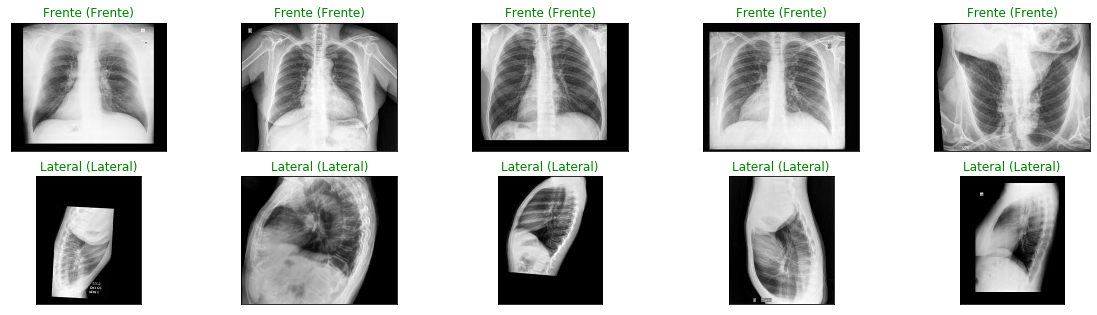

In [36]:
y_true = [0,0,0,0,0,1,1,1,1,1]
labels = ['Frente', 'Lateral']
figure = plt.figure(figsize=(20, 8))
for i in range(10):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    im = plt.imread(test_set[i])
    ax.imshow(im)
    predict_index = np.argmax(y_pred[i])
    true_index = y_true[i]
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Transfer Learning

Nem sempre precisamos definir a arquitetura da nossa rede do zero. Para reconhecimento de imagens existem arquiteturas já definidas e pré-treinadas com o Imagenet - um dataset com 1.2 milhões de imagens e 1000 categorias.

![](https://cdn-images-1.medium.com/max/1400/1*n16lj3lSkz2miMc_5cvkrA.jpeg)
[referência](https://towardsdatascience.com/neural-network-architectures-156e5bad51ba)

Para usar essas redes utilizamos **transfer learning**, transferir os pesos já aprendidos nessas redes para uma tarefa.

In [0]:
data_generator = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip=True, 
                              vertical_flip=False, 
                              height_shift_range=0.1, 
                              width_shift_range=0.1, 
                              brightness_range=[0.7, 1.5],
                              rotation_range=3, 
                              shear_range=0.01,
                              fill_mode='nearest',
                              zoom_range=0.125,
                              rescale = 1./255, validation_split=0.30)

In [27]:
path = '/content/drive/images-chest-orientation/train/'
BATCH_SIZE = 50


train_generator = data_generator.flow_from_directory(path, shuffle=True, seed=13, classes=['frente', 'lateral'],
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(path, shuffle=True, seed=13, classes=['frente', 'lateral'],
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 1142 images belonging to 2 classes.
Found 488 images belonging to 2 classes.


In [0]:
from keras.applications import MobileNet

### **Usaremos a MobileNet**



![alt text](https://i.ytimg.com/vi/onKT9OwMiMU/maxresdefault.jpg)

In [0]:
def build_model(shape):
    '''
    Constroi as camadas da rede
    :return: modelo construido
    '''
    
    base_model = MobileNet(weights = "imagenet", include_top=False, input_shape = shape)
    # congelando camadas que não iremos treinar.
    # para congelar alguns layers específicos basta passar o indice: for layer in mobile.layers[:5]:
    for layer in base_model.layers[:3]:
        layer.Trainable=False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='sigmoid')(x)
    
    model = Model(input = base_model.input, output = predictions)

    return model

In [30]:
model = build_model(shape)


17227776/17225924 [==============================] - 2s 0us/step


In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32)      128 

In [0]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [33]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch = train_generator.samples//BATCH_SIZE,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//BATCH_SIZE,
                    epochs= 50,
                    callbacks=[checkpoint, early_stop]
                    )

Epoch 1/50
22/22 [==============================] - 44s 2s/step - loss: 0.0641 - acc: 0.9700 - val_loss: 1.5399 - val_acc: 0.7467

Epoch 00001: val_loss did not improve from 0.10035
Epoch 2/50
22/22 [==============================] - 38s 2s/step - loss: 0.0080 - acc: 0.9991 - val_loss: 0.9260 - val_acc: 0.8253

Epoch 00002: val_loss did not improve from 0.10035
Epoch 3/50
22/22 [==============================] - 37s 2s/step - loss: 0.0050 - acc: 0.9982 - val_loss: 0.1838 - val_acc: 0.9783

Epoch 00003: val_loss did not improve from 0.10035
Epoch 4/50
22/22 [==============================] - 36s 2s/step - loss: 7.5687e-04 - acc: 1.0000 - val_loss: 0.1872 - val_acc: 0.9772

Epoch 00004: val_loss did not improve from 0.10035
Epoch 5/50
22/22 [==============================] - 36s 2s/step - loss: 0.0033 - acc: 0.9991 - val_loss: 0.1855 - val_acc: 0.9874

Epoch 00005: val_loss did not improve from 0.10035
Epoch 00005: early stopping


- Vamos visualizar algumas classificações

In [0]:
y_pred = model.predict(image_test)

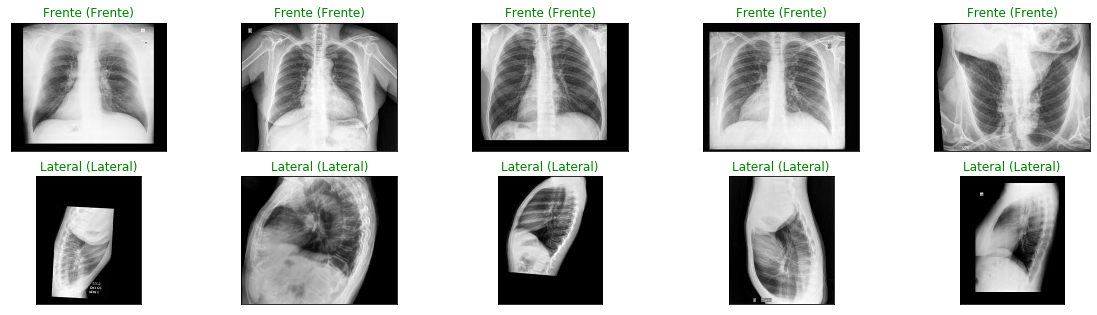

In [37]:
y_true = [0,0,0,0,0,1,1,1,1,1]
labels = ['Frente', 'Lateral']
figure = plt.figure(figsize=(20, 8))
for i in range(10):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    im = plt.imread(test_set[i])
    ax.imshow(im)
    predict_index = np.argmax(y_pred[i])
    true_index = y_true[i]
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Razões de porque sua rede pode não estar funcionando:

https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607